# Complete Statistical Analysis

## Preliminaries

### Imports

In [35]:
import numpy as np
import math
import itertools
import os

import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro, kstest, jarque_bera




# ....

### Utility Functions

In [36]:
def load_data(file_path):
    """
    Loads csv data
    """
    data = pd.read_csv(file_path)
    return data
    
def find_data_folder(folder_path, start_path='/content/drive'):
  '''
    :file_path: The complete path of the folder that includes the files.
    :start_path: The root folder on Drive from which we start the search
  '''
  #Search the root folder of the data and if found, continue searching the full path.
  start_data_folder = folder_path.split('/')[0]
  for root, dirs, files in os.walk(start_path):
      if start_data_folder in dirs:
          return os.path.join(root, folder_path)
  raise Exception(f"{start_data_folder} folder not found. Please check the directory structure.")


def plot_signal_segment(raw_signal, cleaned_signal, title, start_time, duration, sampling_rate=1000):
    """ Utility. Makes two graphs of a raw and a cleaned signal for demonstration """
    start_sample = int(start_time * sampling_rate)
    end_sample = int((start_time + duration) * sampling_rate)

    plt.figure(figsize=(14, 6))
    # Plot raw signal
    plt.subplot(2, 1, 1)
    plt.plot(raw_signal[start_sample:end_sample], label='Raw Signal')
    plt.title(f'Raw {title} Segment ({start_time}-{start_time + duration} sec)')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    
    # Plot clean signal
    plt.subplot(2, 1, 2)
    plt.plot(cleaned_signal[start_sample:end_sample], label='Cleaned Signal')
    plt.title(f'Cleaned {title} Segment ({start_time}-{start_time + duration} sec)')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.tight_layout()
    plt.show()

def preprocess_signal(signal, data_type, visualization=False):
    """ Just cleans the signal (NOTE: ok for now).
    Set visualization to True to see a before-after example
    """
    if data_type == "ecg":
        cleaned_signal = nk.ecg_clean(signal, sampling_rate=1000)
    elif data_type == "gsr":
        cleaned_signal = nk.eda_clean(signal, sampling_rate=1000)
    else:
        raise ValueError("Unsupported data type")

    if visualization:
        # Plot a 5-second segment for demonstration
        plot_signal_segment(signal, cleaned_signal, 'Signal', start_time=400, duration=5 if data_type=='ecg' else 200)
    return cleaned_signal


def extract_segments(cleaned_signal, start_time, end_time, original_timestamps):
    """ Utility. Extracts the signal segment given timestamps """
    start_index = original_timestamps[original_timestamps >= start_time].index[0]
    end_index = original_timestamps[original_timestamps <= end_time].index[-1]

    segment = cleaned_signal[start_index:end_index+1]
    return segment


# ....

### Independent Variables (Predictors)

#### TODO: Add your code here

### Dependent Variables (Features Extraction)

#### Preprocessing

In [37]:
def extract_features(segment, data_type, sampling_rate=1000):
    """ Extracts ECG and GSR features.

    ECG:
    - Heart Rate: Mean heart rate over the segment.
    - HRV SDNN: Standard deviation of NN intervals (HRV time-domain).
    - Mean RR Interval: Mean of RR intervals.
    - Poincaré SD1: Standard deviation of the points perpendicular to the line of identity in the Poincaré plot (HRV non-linear).
    - LF/HF Ratio: Ratio of low-frequency to high-frequency power (HRV frequency-domain).
    - RSA: Respiratory sinus arrhythmia, approximated by RMSSD.
    - PSD Total Power: Total power of the power spectral density.
    - PSD LF Power: Power in the low-frequency band of the PSD.
    - PSD HF Power: Power in the high-frequency band of the PSD.

    GSR:
    - SCL: Skin conductance level (mean tonic level).
    - SCR: Skin conductance response (mean phasic level).
    - Peak Amplitude: Maximum amplitude of the SCR peaks.
    - PSD Total Power: Total power of the power spectral density.
    - PSD LF Power: Power in the low-frequency band of the PSD.
    - PSD HF Power: Power in the high-frequency band of the PSD.

    Parameters:
    - segment: Array-like, the segment of the signal to analyze.
    - data_type: str, type of the signal ("ecg" or "gsr").
    - sampling_rate: int, sampling rate of the signal in Hz.

    Returns:
    - dict: A dictionary containing the extracted features.
    """
    if data_type == "ecg":
        signals, info = nk.ecg_process(segment, sampling_rate=sampling_rate)
        heart_rate = signals['ECG_Rate']

        peaks, info = nk.ecg_peaks(segment, sampling_rate=sampling_rate)
        hrv_time = nk.hrv_time(peaks, sampling_rate=sampling_rate).iloc[0].to_dict()
        hrv_nonlinear = nk.hrv_nonlinear(peaks, sampling_rate=sampling_rate).iloc[0].to_dict()
        hrv_frequency = nk.hrv_frequency(peaks, sampling_rate=sampling_rate).iloc[0].to_dict()

        psd = nk.signal_psd(segment, sampling_rate=sampling_rate)

        features = {
            "Heart Rate": heart_rate.mean(),
            "HRV SDNN": hrv_time['HRV_SDNN'],
            "Mean RR Interval": hrv_time['HRV_MeanNN'],
            "Poincaré SD1": hrv_nonlinear['HRV_SD1'],
            "LF/HF Ratio": hrv_frequency['HRV_LFHF'],
            "RSA": hrv_time['HRV_RMSSD'],
            "PSD Total Power": psd['Power'].sum(),
            "PSD LF Power": psd['Power'][psd['Frequency'] <= 0.15].sum(),
            "PSD HF Power": psd['Power'][(psd['Frequency'] > 0.15) & (psd['Frequency'] <= 0.4)].sum()
        }
    elif data_type == "gsr":
        signals, info = nk.eda_process(segment, sampling_rate=sampling_rate)
        scl = signals['EDA_Tonic'].mean()
        scr = signals['EDA_Phasic'].mean()

        peaks, info = nk.eda_peaks(segment, sampling_rate=sampling_rate)
        peak_amplitude = signals['EDA_Phasic'].max()
        # this is not useful now, cause it's always one
        # peak_frequency = len(peaks['SCR_Peaks']) / len(segment)

        psd = nk.signal_psd(segment, sampling_rate=sampling_rate)

        features = {
            "SCL": scl,
            "SCR": scr,
            "Peak Amplitude": peak_amplitude,
            "PSD Total Power": psd['Power'].sum(),
            "PSD LF Power": psd['Power'][psd['Frequency'] <= 0.15].sum(),
            "PSD HF Power": psd['Power'][(psd['Frequency'] > 0.15) & (psd['Frequency'] <= 0.4)].sum()
        }
    else:
        raise ValueError("Unsupported data type")
    return features


# TODO: Fix this with new segmentation approach
def get_segment_timestamps(data):
    """ Gets the df data based on the timestamps
    (NOTE: this allows for further segmentation by being flexible and
    not relying on adding new df columns or indices)
    """
    # Get data only for videos 7 and 8 (scary videos)
    scary_1_data = data[data['video'] == 7]
    scary_2_data = data[data['video'] == 8]

    # Get the start and end timestamps
    scary_1_start = scary_1_data['daqtime'].iloc[0]
    scary_1_end = scary_1_data['daqtime'].iloc[-1]
    scary_2_start = scary_2_data['daqtime'].iloc[0]
    scary_2_end = scary_2_data['daqtime'].iloc[-1]

    # Swap the videos if needed (based on presented order)
    if scary_1_start > scary_2_start: # compare start timestamps
        (scary_1_start, scary_1_end), (scary_2_start, scary_2_end) = (scary_2_start, scary_2_end), (scary_1_start, scary_1_end)

    return (scary_1_start, scary_1_end), (scary_2_start, scary_2_end)



##### Load Raw Data

In [38]:
using_full = False
if using_full:
  base_dir = find_data_folder('CASE_full/data/interpolated/physiological')
  total_num_participants = 30
else:
  base_dir = find_data_folder('CASE_snippet/data/interpolated/physiological')
  total_num_participants = 2

# Participants to include
sub_nums = range(1, total_num_participants+1)

Exception: CASE_snippet folder not found. Please check the directory structure.

##### Clean Signal and Extract Features from ECG and GSR data

In [ ]:
# Initialize list (NOTE: we will convert to dataframe later)
results = []

for sub_num in sub_nums:
    print(f"\n----------- Participant {sub_num} data -----------------\n")
    data_path = os.path.join(base_dir, f'sub_{sub_num}.csv')
    data = load_data(data_path)

    ecg_signal = data['ecg']
    gsr_signal = data['gsr']
    original_timestamps = data['daqtime']

    # Clean signals (set to True to visualize before-after)
    ecg_cleaned = preprocess_signal(ecg_signal, data_type="ecg", visualization=False)
    gsr_cleaned = preprocess_signal(gsr_signal, data_type="gsr", visualization=False)

    # Get timestamps for scary videos
    (scary_1_start, scary_1_end), (scary_2_start, scary_2_end) = get_segment_timestamps(data)

    # Extract segment data (NOTE: something like this could be used later even if we segment the videos further)
    ecg_scary_1_segment = extract_segments(ecg_cleaned, scary_1_start, scary_1_end, original_timestamps)
    ecg_scary_2_segment = extract_segments(ecg_cleaned, scary_2_start, scary_2_end, original_timestamps)

    gsr_scary_1_segment = extract_segments(gsr_cleaned, scary_1_start, scary_1_end, original_timestamps)
    gsr_scary_2_segment = extract_segments(gsr_cleaned, scary_2_start, scary_2_end, original_timestamps)

    # Calculate ECG and GSR features for both videos
    ecg_features_scary_1 = extract_features(ecg_scary_1_segment, data_type="ecg")
    ecg_features_scary_2 = extract_features(ecg_scary_2_segment, data_type="ecg")

    gsr_features_scary_1 = extract_features(gsr_scary_1_segment, data_type="gsr")
    gsr_features_scary_2 = extract_features(gsr_scary_2_segment, data_type="gsr")

    # Calculate differences for all features (to use in statistical analysis)
    ecg_features_diff = {f'diff_ecg_{key}': ecg_features_scary_2[key] - ecg_features_scary_1[key] for key in ecg_features_scary_1.keys()}
    gsr_features_diff = {f'diff_gsr_{key}': gsr_features_scary_2[key] - gsr_features_scary_1[key] for key in gsr_features_scary_1.keys()}

    # Compile all features into a single dictionary
    participant_features = {'participant': sub_num}
    participant_features.update({f'scary_1_ecg_{key}': value for key, value in ecg_features_scary_1.items()})
    participant_features.update({f'scary_2_ecg_{key}': value for key, value in ecg_features_scary_2.items()})
    participant_features.update(ecg_features_diff)
    participant_features.update({f'scary_1_gsr_{key}': value for key, value in gsr_features_scary_1.items()})
    participant_features.update({f'scary_2_gsr_{key}': value for key, value in gsr_features_scary_2.items()})
    participant_features.update(gsr_features_diff)

    # Add to results
    results.append(participant_features)

##### Save to csv

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save
output_filepath = 'extracted_features.csv'
results_df.to_csv(output_filepath, index=False)

print(f"Results saved to {output_filepath}.")

## Statistical Analysis

### Preprocessing 

### TODO: (rescale, transform variables if needed, round, combine dfs based on participant number as index)

In [ ]:
# TODO: here you load the extracted_features.csv and combine with your independent variables df, to create iv_dv_clean.csv (after rounding, ms to sec etc.)

### Correlation

In [164]:
data_path = "output_data/iv_dv_clean.csv"
data = load_data(data_path)
data.head()

,Interlude Duration,Log Ratio,Low Arous. time before 2nd,diff_ecg_Heart Rate,diff_ecg_HRV SDNN,diff_ecg_Mean RR Interval,diff_ecg_Poincaré SD1,diff_ecg_LF/HF Ratio,diff_ecg_RSA,diff_ecg_PSD Total Power,diff_ecg_PSD LF Power,diff_ecg_PSD HF Power,diff_gsr_SCL,diff_gsr_SCR,diff_gsr_Peak Amplitude,diff_gsr_PSD Total Power,diff_gsr_PSD LF Power,diff_gsr_PSD HF Power
0,959.958333,-0.2877,386750.000,-5.239475,-63.649916,46.897892,-10.268864,-1.062118,-14.521935,-210.555512,-1.130000e-07,-0.071399,-4.907596,0.000063,-0.444185,0.016376,0.016010,0.000237
1,929.375000,-0.2877,623791.667,-0.513969,20.286824,7.116465,4.303694,0.684604,6.116541,21.439281,8.395812e-09,0.083480,3.355576,0.001696,-0.571826,0.147734,0.153973,-0.006105
2,1237.458333,-0.5108,400125.000,9.686036,5.121288,-91.967860,-21.136695,0.587605,-29.835667,-248.841648,-2.520000e-08,-0.043045,2.255484,-0.004137,0.114779,0.032012,0.031664,0.000335
3,890.541667,0.0000,890541.667,0.865101,-25.110028,-8.577620,-20.690543,0.329617,-29.065799,46.972888,-1.110000e-08,0.003408,9.230335,0.003017,0.763255,0.134367,0.133171,0.001194
4,623.791667,0.0000,623791.667,4.835005,-19.139729,-57.398730,-6.256299,-1.700857,-8.808362,-22.099572,4.335439e-10,-0.022623,1.360499,-0.004445,-1.698186,-0.227748,-0.319633,0.079484


In [166]:
relevant_columns = ['Interlude Duration', 'Log Ratio', 'diff_ecg_Mean RR Interval', 'diff_ecg_Heart Rate', 'diff_ecg_HRV SDNN', 'diff_gsr_Peak Amplitude', 'diff_gsr_SCR', 'diff_gsr_SCL']
data = data[relevant_columns]
data.head()

,Interlude Duration,Log Ratio,diff_ecg_Mean RR Interval,diff_ecg_Heart Rate,diff_ecg_HRV SDNN,diff_gsr_Peak Amplitude,diff_gsr_SCR,diff_gsr_SCL
0,959.958333,-0.2877,46.897892,-5.239475,-63.649916,-0.444185,0.000063,-4.907596
1,929.375000,-0.2877,7.116465,-0.513969,20.286824,-0.571826,0.001696,3.355576
2,1237.458333,-0.5108,-91.967860,9.686036,5.121288,0.114779,-0.004137,2.255484
3,890.541667,0.0000,-8.577620,0.865101,-25.110028,0.763255,0.003017,9.230335
4,623.791667,0.0000,-57.398730,4.835005,-19.139729,-1.698186,-0.004445,1.360499


In [167]:
# Calculate the Pearson correlation matrix
correlation_matrix = data.corr(method='pearson')
correlation_matrix

,Interlude Duration,Log Ratio,diff_ecg_Mean RR Interval,diff_ecg_Heart Rate,diff_ecg_HRV SDNN,diff_gsr_Peak Amplitude,diff_gsr_SCR,diff_gsr_SCL
Interlude Duration,1.000000,-0.331678,0.096730,-0.065541,-0.025039,0.425979,0.233522,-0.071301
Log Ratio,-0.331678,1.000000,-0.055395,-0.043790,0.077094,-0.185790,-0.389022,0.113073
diff_ecg_Mean RR Interval,0.096730,-0.055395,1.000000,-0.971237,-0.423386,-0.080691,0.149668,-0.553317
diff_ecg_Heart Rate,-0.065541,-0.043790,-0.971237,1.000000,0.353399,0.097516,-0.139974,0.518482
diff_ecg_HRV SDNN,-0.025039,0.077094,-0.423386,0.353399,1.000000,0.239692,0.038119,0.468282
diff_gsr_Peak Amplitude,0.425979,-0.185790,-0.080691,0.097516,0.239692,1.000000,0.384886,0.563651
diff_gsr_SCR,0.233522,-0.389022,0.149668,-0.139974,0.038119,0.384886,1.000000,0.187699
diff_gsr_SCL,-0.071301,0.113073,-0.553317,0.518482,0.468282,0.563651,0.187699,1.000000


### Regression Analyses

### NOTE: ASK LUKAS 
### 1)problem if the interaction term is 0?
### 2)when checking assumptions with or without interaction

### Linear Multiple Regression

##### Assumptions Checking

###### Set up

In [169]:
# Define predictors and response variables
X = data[['Interlude Duration', 'Log Ratio']]
y_vars = ['diff_ecg_Mean RR Interval', 'diff_ecg_Heart Rate', 'diff_gsr_Peak Amplitude', 'diff_gsr_SCL']

# Define model with interaction term
X_w_interaction = X.copy()
X_w_interaction['Interaction'] = X_w_interaction['Interlude Duration'] * X_w_interaction['Log Ratio']

# Add constant to the predictors
X = sm.add_constant(X)
X_w_interaction = sm.add_constant(X_w_interaction)

# Fit models and store in dictionary
models = {}

for i, response_var in enumerate(y_vars, 1):
    model_key = f'model{i}'
    models[model_key] = {
        'model_no_interaction': sm.OLS(data[response_var], X).fit(),
        'model_w_interaction': sm.OLS(data[response_var], X_w_interaction).fit(),
        'response_var': response_var
    }


def derive_formula(model):
    """ Derive linear formulat from model """
    predictors = model.model.exog_names
    response = model.model.endog_names
    formula = f"{response} ~ " + " + ".join(predictors)
    return formula

###### Choose model

In [181]:
model_name = "model2" # put model here... ('model1', 'model2', 'model3', 'model4')

In [182]:
model_info = models[model_name]
model = model_info['model_no_interaction']
# print(model.summary())
response_var = model_info['response_var']
print(f"Selected model: {model_key}\n-Predictors: {', '.join(X.columns.tolist())}\n-Response Variable: {response_var}")

Selected model: model4
-Predictors: const, Interlude Duration, Log Ratio
-Response Variable: diff_ecg_Heart Rate


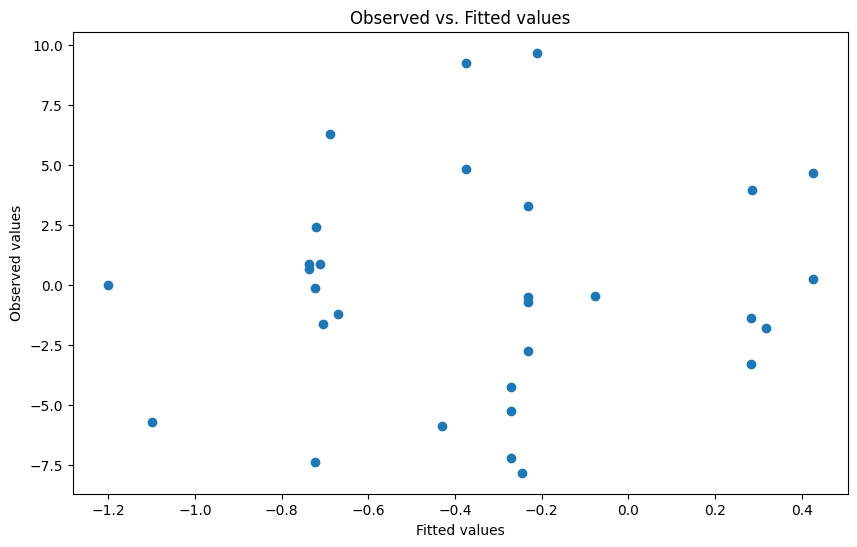

In [183]:
# 1. Linearity: Plot observed vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, y[response_var])
plt.xlabel('Fitted values')
plt.ylabel('Observed values')
plt.title('Observed vs. Fitted values')
plt.show()

In [184]:
# 2. Independence: Durbin-Watson test
dw_test = sm.stats.durbin_watson(model.resid)
print(f'Durbin-Watson statistic: {dw_test}')

Durbin-Watson statistic: 2.0586880378150076


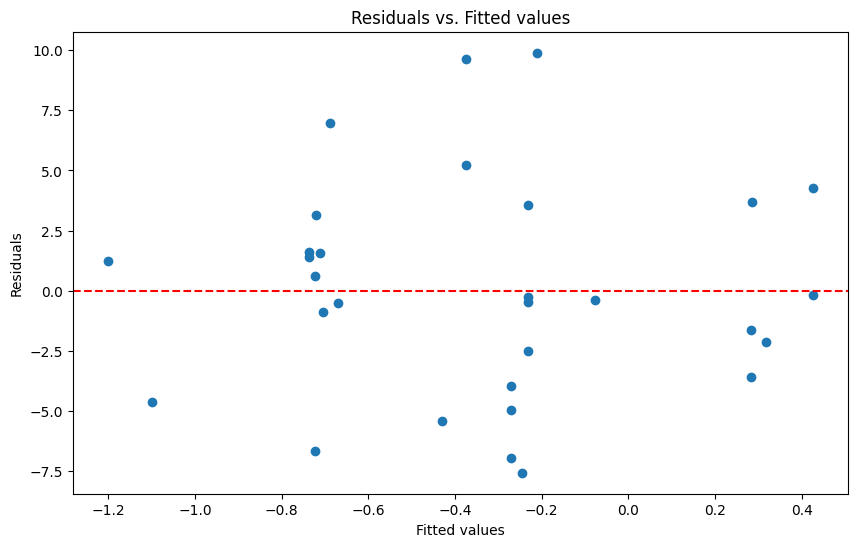

{'LM Statistic': 0.1504653406045564, 'LM-Test p-value': 0.9275276530811194, 'F-Statistic': 0.06805071239266819, 'F-Test p-value': 0.9343728047772765}


In [185]:
# 3. Homoscedasticity: Plot residuals vs. fitted values
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted values')
plt.show()

# Breusch-Pagan test for homoscedasticity
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))

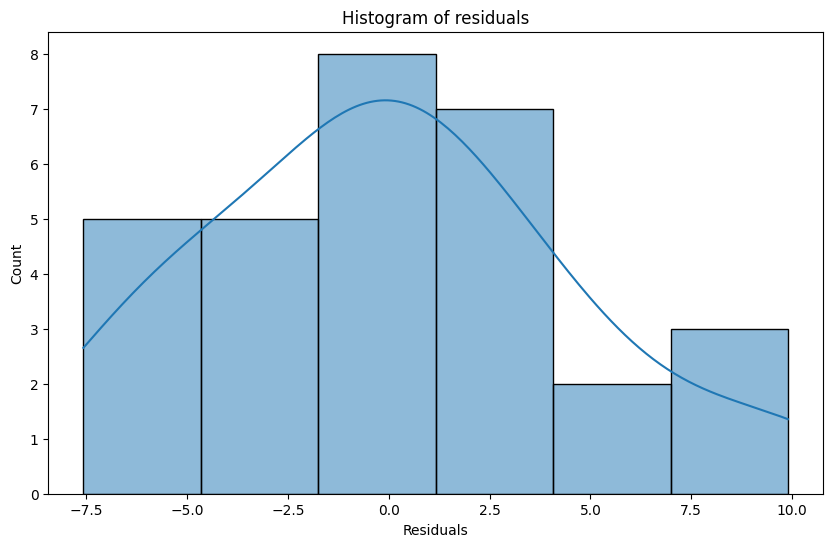

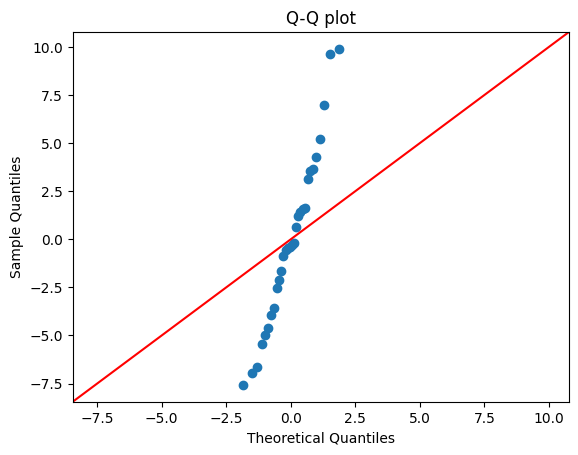

Shapiro-Wilk test: ShapiroResult(statistic=0.9714261293411255, pvalue=0.5788938403129578)
Kolmogorov-Smirnov test: KstestResult(statistic=0.3165263971037769, pvalue=0.003590637361464588, statistic_location=-2.124673424477797, statistic_sign=1)
Jarque-Bera test: SignificanceResult(statistic=0.7871797564102928, pvalue=0.6746306802572481)


In [186]:
# 4. Normality: Histogram and Q-Q plot of residuals
plt.figure(figsize=(10, 6))
sns.histplot(model.resid, kde=True)
plt.xlabel('Residuals')
plt.title('Histogram of residuals')
plt.show()

# Q-Q plot
sm.qqplot(model.resid, line='45')
plt.title('Q-Q plot')
plt.show()

# Shapiro-Wilk test
shapiro_test = shapiro(model.resid)
print(f'Shapiro-Wilk test: {shapiro_test}')

# Kolmogorov-Smirnov test
ks_test = kstest(model.resid, 'norm')
print(f'Kolmogorov-Smirnov test: {ks_test}')

# Jarque-Bera test
jb_test = jarque_bera(model.resid)
print(f'Jarque-Bera test: {jb_test}')

In [187]:
# 5. Multicollinearity: Variance Inflation Factor (VIF)
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


             Variable        VIF
0               const  11.654882
1  Interlude Duration   1.123608
2           Log Ratio   1.123608


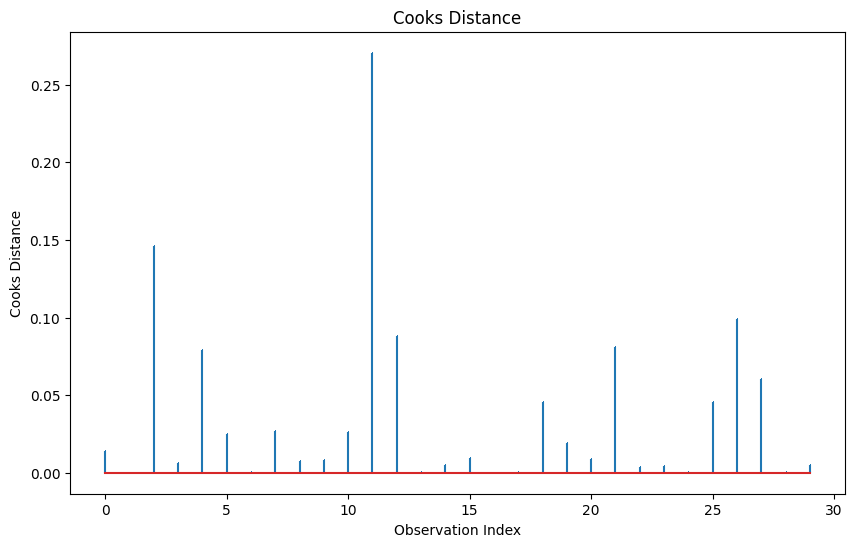

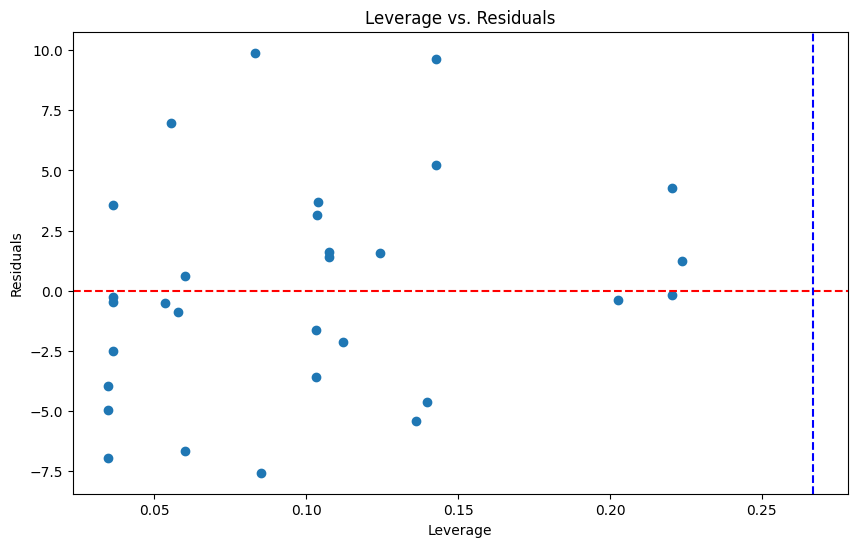

In [188]:
# Additional Assumptions:

# Influential Points: Cook's Distance
influence = OLSInfluence(model)
cooks_d = influence.cooks_distance[0]

plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.title('Cooks Distance')
plt.xlabel('Observation Index')
plt.ylabel('Cooks Distance')
plt.show()

# Leverage plot
plt.figure(figsize=(10, 6))
plt.scatter(influence.hat_matrix_diag, model.resid)
plt.xlabel('Leverage')
plt.ylabel('Residuals')
plt.title('Leverage vs. Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.axvline(2 * (X.shape[1] + 1) / len(X), color='blue', linestyle='--')
plt.show()

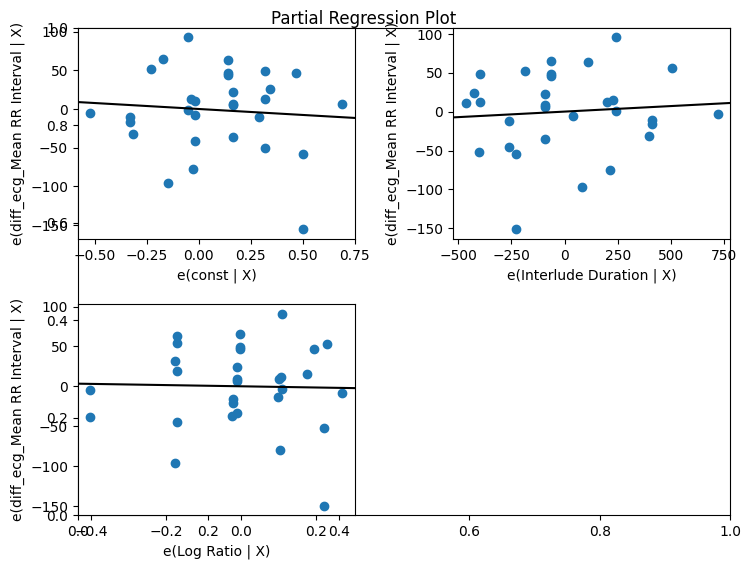

In [180]:
# 7. Linearity of Relationships: Partial Regression Plots
fig, ax = plt.subplots(figsize=(8, 6))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)
plt.show()

##### Fit models

###### change model here (optional)

In [221]:
model_name = "model4" # put model here... ('model1', 'model2', 'model3', 'model4')
# ------
model_info = models[model_name]
model = model_info['model_no_interaction']
# print(model.summary())
response_var = model_info['response_var']
print(f"Selected model: {model_name}\n-Predictors: {', '.join(X.columns.tolist())}\n-Response Variable: {response_var}")

Selected model: model4
-Predictors: const, Interlude Duration, Log Ratio
-Response Variable: diff_gsr_SCL


###### View model summaries

In [222]:
# Print selected model results with and without the interaction term
formula_no_interaction = derive_formula(models[model_name]['model_no_interaction'])
formula_w_interaction = derive_formula(models[model_name]['model_w_interaction'])

print(f"Summary for {formula_no_interaction}:")
print(models[model_name]['model_no_interaction'].summary())

Summary for diff_gsr_SCL ~ const + Interlude Duration + Log Ratio:
                            OLS Regression Results                            
Dep. Variable:           diff_gsr_SCL   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.059
Method:                 Least Squares   F-statistic:                    0.1926
Date:                Sun, 26 May 2024   Prob (F-statistic):              0.826
Time:                        23:24:16   Log-Likelihood:                -105.17
No. Observations:                  30   AIC:                             216.3
Df Residuals:                      27   BIC:                             220.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

In [223]:
print(f"\nSummary for {formula_w_interaction}:")
print(models[model_name]['model_w_interaction'].summary())


Summary for diff_gsr_SCL ~ const + Interlude Duration + Log Ratio + Interaction:
                            OLS Regression Results                            
Dep. Variable:           diff_gsr_SCL   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.181
Date:                Sun, 26 May 2024   Prob (F-statistic):              0.336
Time:                        23:24:17   Log-Likelihood:                -103.47
No. Observations:                  30   AIC:                             214.9
Df Residuals:                      26   BIC:                             220.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Multivariate Multiple Regression

#### Assumptions Checking

/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


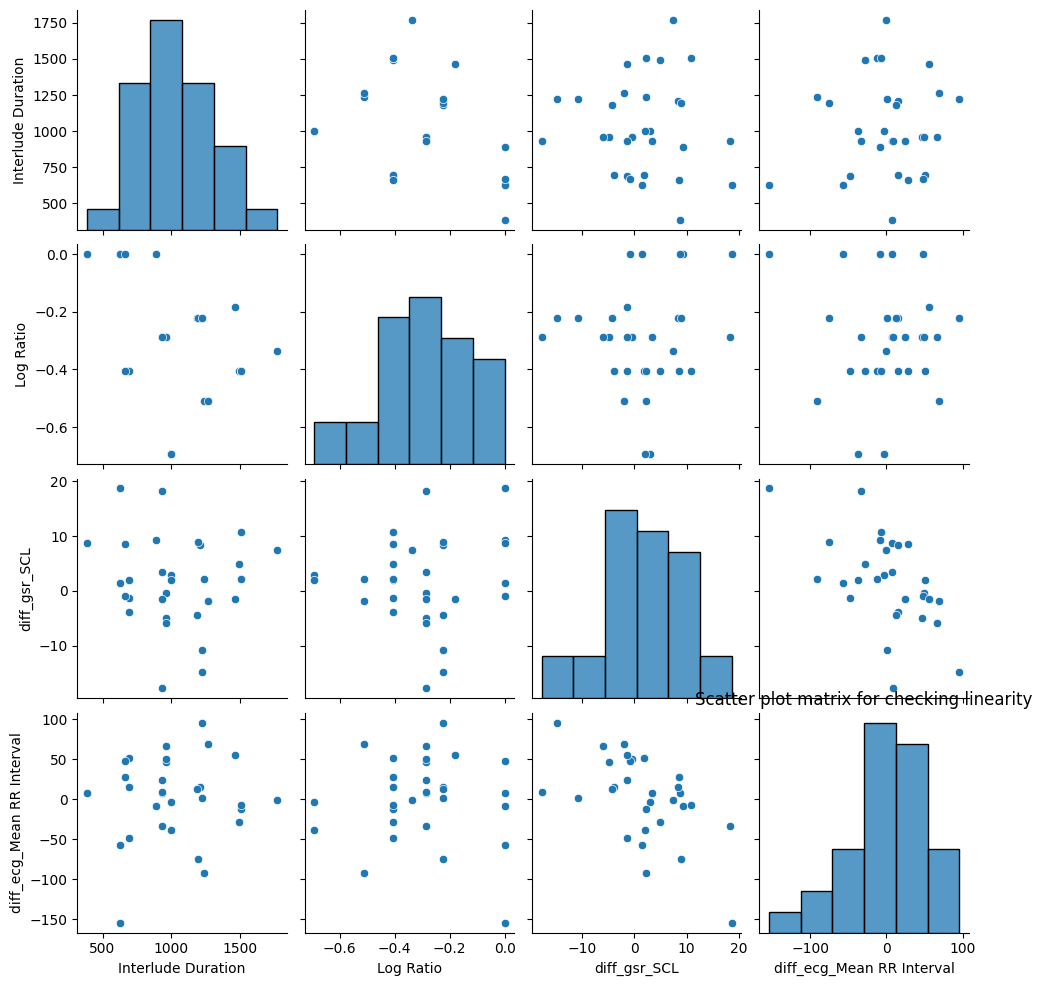

Variance Inflation Factor (without interaction):
             Variable       VIF
0  Interlude Duration  4.036633
1           Log Ratio  4.036633
Shapiro-Wilk test for diff_gsr_SCL: ShapiroResult(statistic=0.9699684977531433, pvalue=0.538313627243042)
Shapiro-Wilk test for diff_ecg_Mean RR Interval: ShapiroResult(statistic=0.9539547562599182, pvalue=0.21549177169799805)
Shapiro-Wilk test for Mahalanobis distances: ShapiroResult(statistic=1.0, pvalue=1.0)


/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.9/site-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


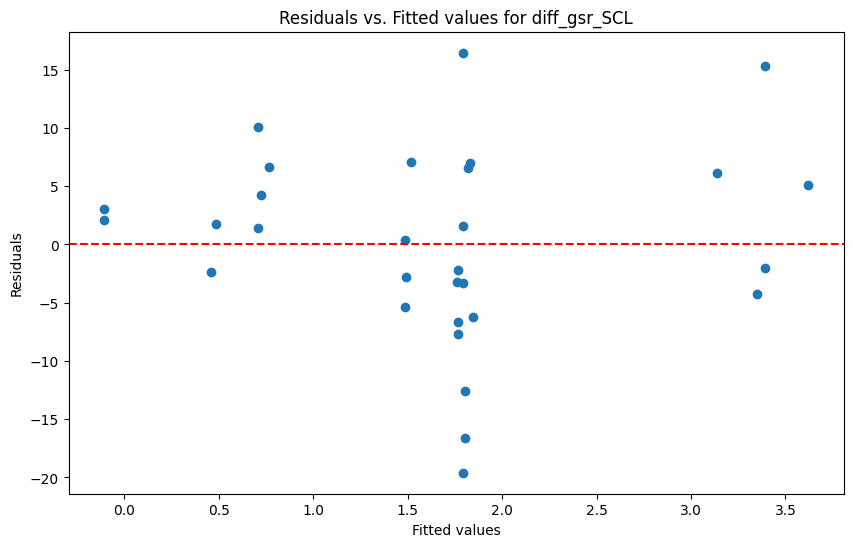

Breusch-Pagan test for diff_gsr_SCL: {'LM Statistic': 1.4709094675728396, 'LM-Test p-value': 0.4792874612111564, 'F-Statistic': 0.6960361315991773, 'F-Test p-value': 0.5072827309000104}


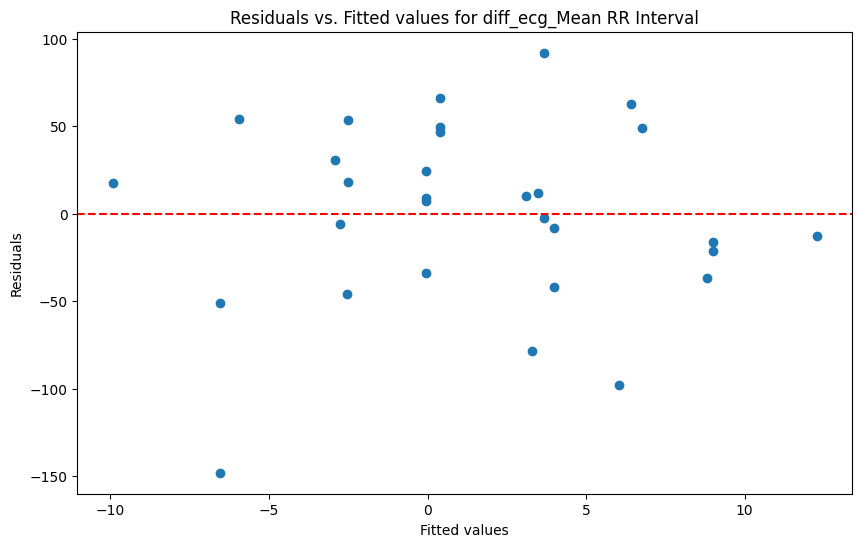

Breusch-Pagan test for diff_ecg_Mean RR Interval: {'LM Statistic': 1.6707995987553037, 'LM-Test p-value': 0.4337010533558636, 'F-Statistic': 0.796203008335017, 'F-Test p-value': 0.4613455497921055}


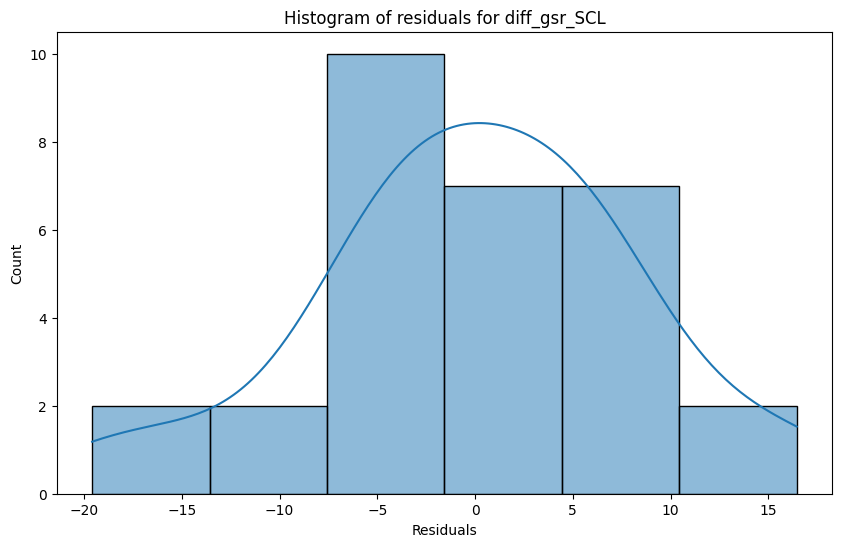

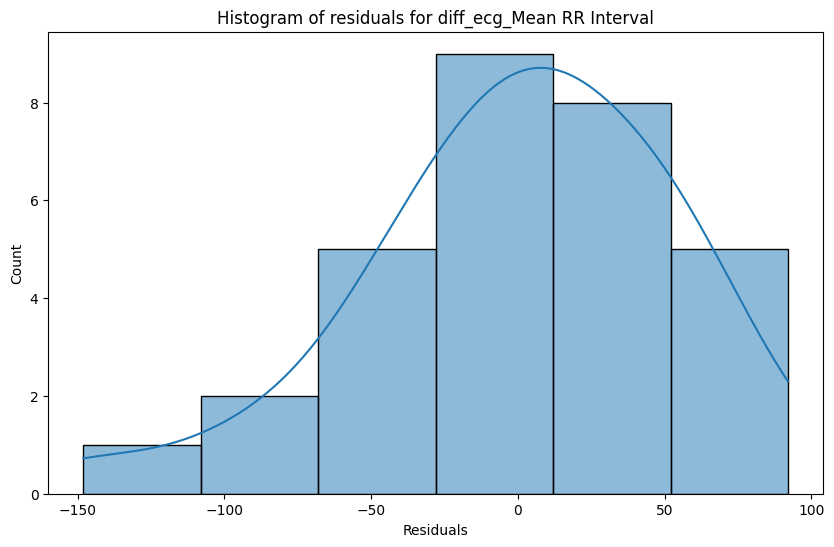

In [224]:
# Filter the relevant columns
relevant_columns = ['Interlude Duration', 'Log Ratio', 'diff_gsr_SCL', 'diff_ecg_Mean RR Interval']
mvar_data = data[relevant_columns]

# Define the formula correctly without the interaction term
formula = 'Q("diff_gsr_SCL") + Q("diff_ecg_Mean RR Interval") ~ Q("Interlude Duration") + Q("Log Ratio")'

# Fit the MANOVA model
mvar_model = MANOVA.from_formula(formula, data=mvar_data)
mvar_model_results = mvar_model.mv_test()


# Check assumptions

# 1. Linearity: Scatter plot matrix
sns.pairplot(mvar_data)
plt.title('Scatter plot matrix for checking linearity')
plt.show()

# 2. Multicollinearity: Variance Inflation Factor (VIF) without interaction term
X_no_interaction = mvar_data[['Interlude Duration', 'Log Ratio']]
vif_no_interaction = pd.DataFrame()
vif_no_interaction['Variable'] = X_no_interaction.columns
vif_no_interaction['VIF'] = [variance_inflation_factor(X_no_interaction.values, i) for i in range(X_no_interaction.shape[1])]
print(f'Variance Inflation Factor (without interaction):\n{vif_no_interaction}')

# 3. Multivariate Normality: Shapiro-Wilk test for each dependent variable
dependent_vars = ['diff_gsr_SCL', 'diff_ecg_Mean RR Interval']
for var in dependent_vars:
    shapiro_test = shapiro(mvar_data[var])
    print(f'Shapiro-Wilk test for {var}: {shapiro_test}')

# Multivariate Normality: Calculate Mahalanobis distances and test for normality
md = mahalanobis_distance(mvar_data[dependent_vars])
shapiro_test_md = shapiro(md)
print(f'Shapiro-Wilk test for Mahalanobis distances: {shapiro_test_md}')

# 4. Homoscedasticity: Plot residuals vs. fitted values and Breusch-Pagan test

# Fit OLS models for each dependent variable to get residuals
X = mvar_data[['Interlude Duration', 'Log Ratio']]
X = sm.add_constant(X)  # Add a constant term to the predictors

residuals = {}
for var in dependent_vars:
    model = sm.OLS(mvar_data[var], X).fit()
    residuals[var] = model.resid

    # Plot residuals vs. fitted values
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues, model.resid)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs. Fitted values for {var}')
    plt.show()

    # Breusch-Pagan test for homoscedasticity
    bp_test = het_breuschpagan(model.resid, model.model.exog)
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    print(f'Breusch-Pagan test for {var}: {dict(zip(labels, bp_test))}')

# Additional check: Plot residuals for normality
for var, resid in residuals.items():
    plt.figure(figsize=(10, 6))
    sns.histplot(resid, kde=True)
    plt.xlabel('Residuals')
    plt.title(f'Histogram of residuals for {var}')
    plt.show()


#### Fit Model 

In [225]:

# Filter the relevant columns
relevant_columns = ['Interlude Duration', 'Log Ratio', 'diff_gsr_SCL', 'diff_ecg_Mean RR Interval']
mvar_data = data[relevant_columns]

mvar_data_w_interaction = mvar_data.copy()

# Add the interaction term to the data
mvar_data_w_interaction['Interaction'] = mvar_data['Interlude Duration'] * mvar_data['Log Ratio']






###### With interaction term

In [226]:
# Define the formula with interaction
formula_w_interaction = 'Q("diff_gsr_SCL") + Q("diff_ecg_Mean RR Interval") ~ Q("Interlude Duration") + Q("Log Ratio") + Interaction'

# Fit the Mutlivariate Multiple Regression (MMR) model
mvar_model_w_interaction = MANOVA.from_formula(formula_w_interaction, data=mvar_data_w_interaction)
mvar_results_w_interaction = mvar_model_w_interaction.mv_test()

# Display the results
print(mvar_results_w_interaction)

                  Multivariate linear model
                                                             
-------------------------------------------------------------
        Intercept        Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.8510 2.0000 25.0000  2.1885 0.1331
          Pillai's trace 0.1490 2.0000 25.0000  2.1885 0.1331
  Hotelling-Lawley trace 0.1751 2.0000 25.0000  2.1885 0.1331
     Roy's greatest root 0.1751 2.0000 25.0000  2.1885 0.1331
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
 Q("Interlude Duration") Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.8640 2.0000 25.0000  1.9674 0.1609
          Pillai's trace 0.1360 2.0000 25.0000  1.9674 0.1609
  Hotelling-Lawley trace 0

###### Without interaction term

In [162]:
# Define the formula without the interaction term
formula_no_interaction = 'Q("diff_gsr_SCL") + Q("diff_ecg_Mean RR Interval") ~ Q("Interlude Duration") + Q("Log Ratio")'

# Fit the Multivariate Multiple Regression (MMR) model without the interaction term
mvar_model_no_interaction = MANOVA.from_formula(formula_no_interaction, data=mvar_data)
mvar_results_no_interaction = mvar_model_no_interaction.mv_test()

# Display the results
print(mvar_results_no_interaction)

                  Multivariate linear model
                                                             
-------------------------------------------------------------
        Intercept        Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.9793 2.0000 26.0000  0.2749 0.7618
          Pillai's trace 0.0207 2.0000 26.0000  0.2749 0.7618
  Hotelling-Lawley trace 0.0211 2.0000 26.0000  0.2749 0.7618
     Roy's greatest root 0.0211 2.0000 26.0000  0.2749 0.7618
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
 Q("Interlude Duration") Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.9929 2.0000 26.0000  0.0924 0.9120
          Pillai's trace 0.0071 2.0000 26.0000  0.0924 0.9120
  Hotelling-Lawley trace 0

## G*Power 